# Global definitions

Load Pylab, define CPTs...

In [177]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [178]:
# Global definition of CPTs
L = array([0.9, 0.1])
P_L = array([[0.8, 0.1],
             [0.2, 0.9]])
T_P = array([[0.8, 0.1],
             [0.2, 0.9]])
B = array([0.99, 0.01])
O_PB = array([[[0.01, 0.7],
               [0.8, 0.999]],
              [[0.99, 0.3],
               [0.2, 0.001]]])

# Some helpers
_l_, _p_, _t_, _b_, _o_ = 0, 1, 2, 3, 4
N_VARS = 5
N_SMPL = 100
na=newaxis

def sample(dist):
    """
    This function samples from a discrete one-dimensional probability distribution
    
    :param dist: probability distribution given as numpy array
    :returns: index of sampled value
    """
    return dist.cumsum().searchsorted(random.sample())

# 1) Approximate Inference Algorithms

Approximate $P(E\mid M, S)$ using various techniques.

## A) Rejection Sampling

In [179]:
def sample_joint(n):
    """
    Samples from the joint distribution.
    :param n: number of samples to create
    :return: Numpy array containing the samples
    """
    smpls = np.empty((n,N_VARS), dtype=int)
    for smpl in smpls:
        smpl[_l_] = sample(L)
        smpl[_p_] = sample(P_L[:, smpl[_l_]])
        smpl[_t_] = sample(T_P[:, smpl[_p_]])
        smpl[_b_] = sample(B)
        smpl[_o_] = sample(O_PB[:, smpl[_p_], smpl[_b_]])
    
    return smpls

In [180]:
def approx_rs(t, o, n):
    """ 
    Approximates P(L | T, O) using rejection sampling
    :param t: given value for T
    :param o: given value for O
    :param n: number of samples to use
    :returns: Numpy array containing the approximated distribution
    """
    smpls = sample_joint(n)
    smpls = smpls[(smpls[:, _t_] == t) & (smpls[:, _o_] == o)]
    
    tot = len(smpls)
    if tot == 0:
        return np.array([NaN, NaN])

    e_counts = bincount(smpls[:, _l_], minlength=2)     
    return e_counts.astype(float) / tot

## B) Likelihood Weighting

In [181]:
def sample_lw(t, o, n=N_SMPL):
    """
    Samples weighted samples given t and o.
    :param t: given value for T
    :param o: given value for O
    :param n: number of samples to create
    :returns: Numpy array containing weights, Numpy array containing the samples
    """
    smpls = np.empty((n,N_VARS), dtype=int)
    weights = np.ones(n)
    for idx, smpl in enumerate(smpls):
        smpl[_l_] = sample(L)
        smpl[_p_] = sample(P_L[:, smpl[_l_]])
        smpl[_t_] = t
        smpl[_b_] = sample(B)
        smpl[_o_] = o
        
        weights[idx] = T_P[t, smpl[_p_]] * O_PB[o, smpl[_p_], smpl[_b_]]
    
    return weights, smpls

In [182]:
def approx_lw(t, o, n):
    """
    Empty implementation of Aiv)
    Approximates P(L | T, O) using likelihood weighting
    :param t: given value for T
    :param o: given value for O
    :param n: number of samples to use
    :returns: Numpy array containing the approximated distribution
    """
    w, smpls = sample_lw(t, o, n)
    l_weights = bincount(smpls[:, _l_], minlength=2, weights=w)
    
    return l_weights / w.sum()

## C) Gibbs Sampling

First, compute the resampling distributions.

In [183]:
tau_L_P = (P_L * L[na, :]).T
tau_L_P /= tau_L_P.sum(0)[na, ...]

tau_B_OP = (O_PB * B[na, na, :]).transpose((2, 0, 1))
tau_B_OP /= tau_B_OP.sum(0)[na, ...]

TOPLB = T_P[:, na, :, na, na] * P_L[na, na, :, :, na] * L[na, na, na, :, na] * O_PB[na, :, :, na, :] * B[na, na, na, na, :]
tau_P_TOLB = TOPLB.transpose((2, 0, 1, 3, 4))
tau_P_TOLB /= tau_P_TOLB.sum(0)[na, ...]

Then, some helper functions.

In [184]:
def gibbs_mcmc(smpl, t, o, n=1):
    """
    Performs MCMC sampling, returning the last sample obtained
    :param smpl: sample to start from
    :param t: given value for T
    :param o: given value for O
    :param n: number of MCMC steps to take
    :returns: new sample after MCMC steps
    """
    for j in range(n):
        smpl[_t_] = t
        smpl[_o_] = o
        smpl[_b_] = sample(tau_B_OP[:, smpl[_o_], smpl[_p_]])
        smpl[_p_] = sample(tau_P_TOLB[:, smpl[_t_], smpl[_o_], smpl[_l_], smpl[_b_]])
        smpl[_l_] = sample(tau_L_P[:, smpl[_p_]])

    return smpl  

def sample_gibbs(t, o, n_burn_in_samples=0, sample_distance=1, n=N_SMPL):
    """
    Samples from P(L | T, O) using Gibbs sampling.
    :param t: given value for T
    :param o: given value for O
    :param n_burn_in_samples: number of burn-in samples to throw away
    :param sample_distance: number of samples to throw away between steps
    :param n: number of samples to return
    :returns: samples obtained using Gibbs sampling
    """
    smpls = np.empty((n, N_VARS), dtype=int)
    smpl = sample_lw(t, o)[1][0]
    
    # burn in time
    smpls[0] = gibbs_mcmc(smpl, t, o, n_burn_in_samples)
    
    for j in range(1, n):
        smpls[j,:] = gibbs_mcmc(smpls[j-1].copy(), t, o, sample_distance)
        
    return smpls

In [185]:
def approx_gibbs(t, o, n, n_burn_in_samples=0, sample_distance=1):
    """ 
    Approximates P(L | T, O) using Gibbs sampling
    :param t: given value for T
    :param o: given value for O
    :param n: number of samples to use
    :param n_burn_in_samples: number of burn-in samples to throw away
    :param sample_distance: number of samples to throw away between steps
    :returns: Numpy array containing the approximated distribution
    """
    smpls = sample_gibbs(t, o, n_burn_in_samples=n_burn_in_samples, sample_distance=sample_distance, n=n)
    
    l_counts = bincount(smpls[:, _l_], minlength=2)   
    return l_counts.astype(float) / smpls.shape[0]

# 2) Comparison

## A) Exact Inference

In [186]:
def exact(t, o):
    """ 
    Computes P(L | T, O) using exact inference
    :param t: given value for T
    :param o: given value for O
    :returns: Numpy array containing the distribution
    """
    OTPLB = T_P[na, :, :, na, na] * P_L[na, na, :, :, na] * L[na, na, na, :, na] * B[na, na, na, na, :] * O_PB[:, na, :, na, :]
    OTL = OTPLB.sum((2, 4))
    LTO = OTL.transpose((2, 1, 0))
    L_TO = LTO / LTO.sum(0)[na, ...]
    
    return L_TO[:, t, o]

## B) Compute and plot estimation errors

In [187]:
def kld(p, q):
    """
    Computes the Kullback-Leibler divergence between p and q.
    :param p: true distribution
    :param q: estimated distribution
    :return: Kullback-Leibler Divergence between p and q
    """
    return (p * np.log(p / (q + 0.00000000001))).sum()  # add a small constant for numeric stability


def compute_approximation_error(approx_function, t, o, n_runs, sample_counts, **kwargs):
    """
    Computes the approximation error for a given approximation method.
    :param approx_function: function used to approximate the distribution
    :param m: given value for M
    :param s: given value for S
    :param n_runs: number of approximations
    :param sample_counts: list or array of numbers of sampels to use
    :returns: mean approximation error for each of the sample counts
    """
    mean_errors = []
    correct = exact(t, o)
    
    for num_samples in sample_counts:
        estimates = array([approx_function(t, o, n=num_samples, **kwargs) for i in range(n_runs)])
        mean_errors.append(abs(estimates - correct).mean())       
        #mean_errors.append(kld(correct, estimates))  # use this instead of the line above for KLD!
    
    return mean_errors

### Compute the estimation errors


In [188]:
rs_errs = {}
lw_errs = {}
gb_errs = {}
n_runs = 100
sample_counts = array([10, 20, 40, 80, 160, 320, 640, 1280])

for t, o in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    rs_errs[(t, o)] = compute_approximation_error(approx_rs, t, o, n_runs, sample_counts)
    lw_errs[(t, o)] = compute_approximation_error(approx_lw, t, o, n_runs, sample_counts)
    gb_errs[(t, o)] = compute_approximation_error(approx_gibbs, t, o, n_runs, sample_counts)

### Plot the estimation errors

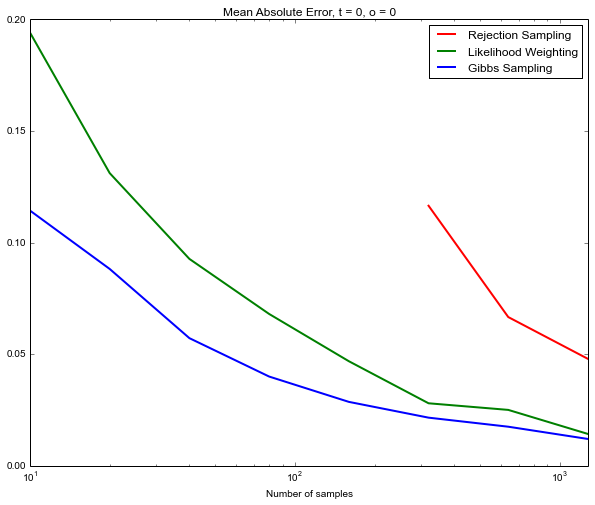

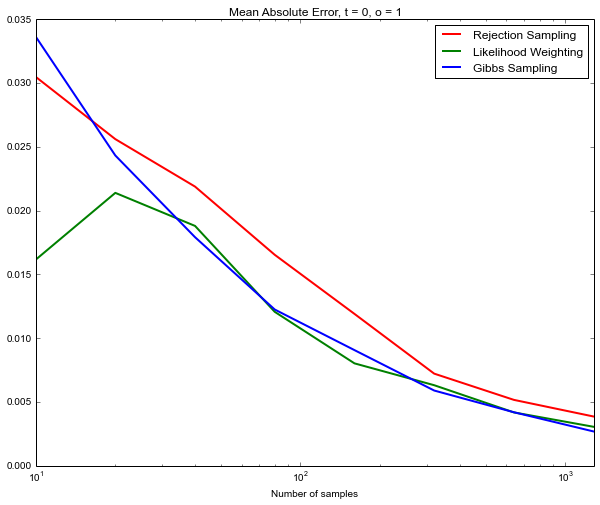

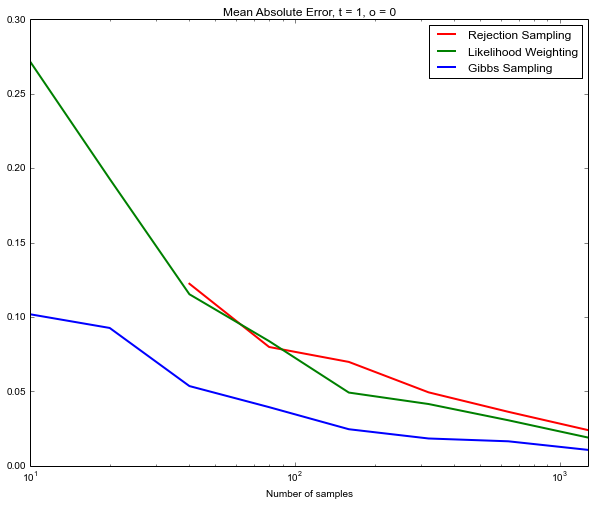

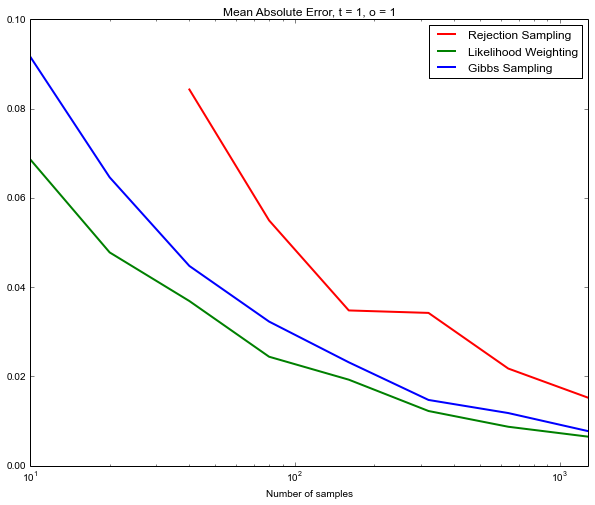

In [189]:
for t, o in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    figure(figsize=(10, 8))
    title('Mean Absolute Error, t = %d, o = %d' % (t, o))

    plot(sample_counts, rs_errs[(t, o)], 'r', label='Rejection Sampling', lw=2)
    plot(sample_counts, lw_errs[(t, o)], 'g', label='Likelihood Weighting', lw=2)
    plot(sample_counts, gb_errs[(t, o)], 'b', label='Gibbs Sampling', lw=2)   
    
    legend()
    xscale('log')
    xlim(sample_counts.min(), sample_counts.max())
    xlabel('Number of samples')
    #ylim(0, 0.4)

We compute P(O, T) in order to get a feeling of how probable the four cases are:

In [190]:
OTPLB = T_P[na, :, :, na, na] * P_L[na, na, :, :, na] * L[na, na, na, :, na] * B[na, na, na, na, :] * O_PB[:, na, :, na, :]
OT = OTPLB.sum(2).sum(2).sum(2)

|               | $o^0$         | $o^1$  |
| ------------- |:-------------:| ------:|
| $t^0$         | 0.032         | 0.579  |
| $t^1$         | 0.197         | 0.192  |

As we see, $(t^0, o^0)$ is the most improbable combination. Therefore, rejection sampling and likelihood weighting have a hard time estimating it, because most samples that are generated are wither not conform with the evidence and get discarded or have low weight respectively. In contrast, $(t^0, o^1)$ is the most easy one and in this case the three sampling methods perform about the same.

### Further improving Gibbs sampling

One problem with Gibbs sampling is, that the samples are highly correlated. What you can do to solve this problem is that you draw more samples and only use every n*-th* sample to compute the distribution. Off course this is somehow cheating because then you basically use much more samples than in the other methods. To show that this works, we now only use every *100-th* sample. Then we get the following plot for $(t^1, o^1)$:

In [192]:
gb_errs = {}
n_runs = 100
sample_counts = array([10, 20, 40, 80, 160, 320, 640, 1280])
t = 1
o = 1
gb_errs[(t, o)] = compute_approximation_error(approx_gibbs, t, o, n_runs, sample_counts, sample_distance=100)

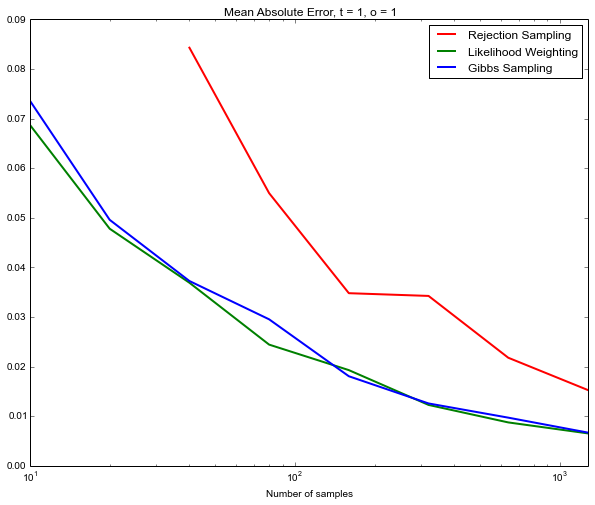

In [193]:
figure(figsize=(10, 8))
title('Mean Absolute Error, t = %d, o = %d' % (t, o))

plot(sample_counts, rs_errs[(t, o)], 'r', label='Rejection Sampling', lw=2)
plot(sample_counts, lw_errs[(t, o)], 'g', label='Likelihood Weighting', lw=2)
plot(sample_counts, gb_errs[(t, o)], 'b', label='Gibbs Sampling', lw=2)   
    
legend()
xscale('log')
xlim(sample_counts.min(), sample_counts.max())
xlabel('Number of samples')

Now, Gibbs sampling works comparable to likelihood sampling.